In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

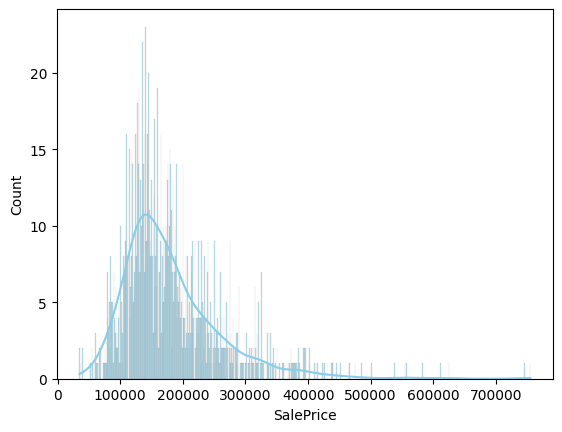

In [12]:
df_train = pd.read_csv("train.csv")
x_train = df_train.drop(columns=['SalePrice'])
y_train = df_train.iloc[:,-1]

df_test = pd.read_csv("test.csv")
x_test = df_test

sns.histplot(y_train, kde=True, bins=700, color='skyblue', edgecolor='black')
plt.show()

**DATA CLEANING**

In [13]:
columns = df_train.columns
#first identifying columns with most number of null values
number_of_nulls = x_train.isnull().sum()
null_cols_sorted = columns[np.argsort(number_of_nulls)[::-1]]
nulls_vs_columns = pd.DataFrame(np.sort(number_of_nulls)[::-1], null_cols_sorted)
nulls_vs_columns.head(25)

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageCond,81
GarageType,81
GarageYrBlt,81


In [14]:
# columns 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType' have more than 50% null values so we are dropping these columns
x_train = x_train.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType','Id'])
x_test = x_test.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType','Id'])

In [15]:
# Now for remaining columns containing null values we will fill the values with its mode
x_train = x_train.fillna(value=x_train.mode().iloc[0])   
x_test = x_test.fillna(value=x_test.mode().iloc[0])

In [16]:
#handling categorical data
#we are first combining the training and test dataset to make sure that while we are one-hot encoding any parameter of a particular column that is not present in the training set but present in test dataset is counted and vice-versa

x_combined = pd.concat([x_train,x_test],axis=0)

categorical_columns=['MSZoning','Street','LotShape','LandContour','Utilities','LotConfig', 'LandSlope',  'Neighborhood', 'Condition2','BldgType','Condition1','HouseStyle','SaleType',
'SaleCondition','ExterCond','ExterQual','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive']

#one-hot encoding

for col in categorical_columns:
    df_encoded = pd.get_dummies(x_combined[col]).astype(int)
    x_combined = pd.concat([x_combined,df_encoded],axis=1)
#since now we have encode all the categorical columns we can safely drop them
    
x_final = x_combined.drop(columns=categorical_columns)



**FEATURE SCALING**

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_final)
transform_matrix = scaler.transform(x_final)
x_final_scaled = pd.DataFrame(transform_matrix, columns=x_final.columns)
x_train_final = x_final_scaled.iloc[:1460,:]
x_test_final = x_final_scaled.iloc[1460:,:]

**Prediction using kNN**

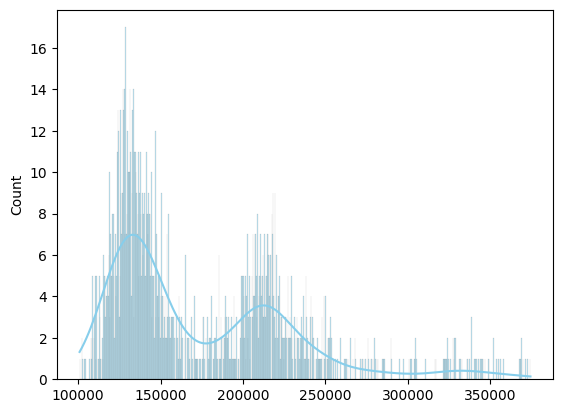

[131547.   137596.16 207255.   ... 134785.5  143690.   191480.6 ]


In [18]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors=50)
knn_regressor.fit(x_train_final, y_train)
y_pred = knn_regressor.predict(x_test_final)
sns.histplot(y_pred, kde=True, bins=700, color='skyblue', edgecolor='black')
plt.show()
print(y_pred)

**CLUSTERING**

C:\Users\Tejas\AppData\Local\Temp\ipykernel_25620\3698395897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train_final['class'] = km.fit_predict(x_train_final)


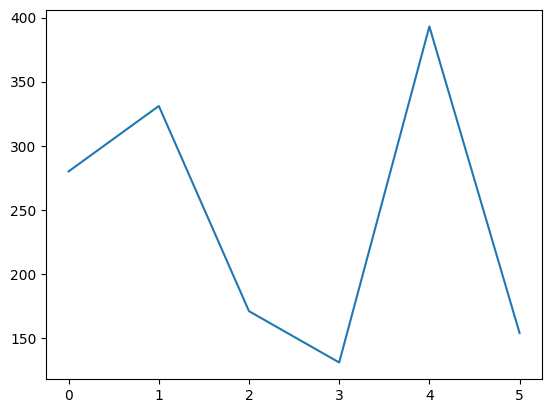

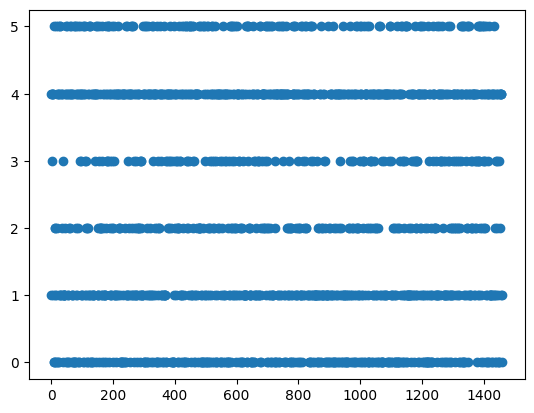

In [19]:
from sklearn.cluster import KMeans
num_of_cluster = 6

km = KMeans(n_clusters=num_of_cluster)
x_train_final['class'] = km.fit_predict(x_train_final)

class_size = []
for i in range(0,num_of_cluster):
    total_in_class_i = np.sum(x_train_final['class']==i)
    class_size.append(total_in_class_i)

plt.plot(np.arange(0,num_of_cluster),class_size)
plt.show()

plt.scatter(np.arange(0,len(x_train_final['class'])),x_train_final['class'])
plt.show()

**GRADIO**

In [20]:
import gradio as gr


def SalePrice(YearBuilt,GrLivArea,TotalBsmtSF,GarageCars,OverallQual):
    feature_vector = [YearBuilt,GrLivArea,TotalBsmtSF,GarageCars,OverallQual]
    #taking any row from x_train_final and modifying the 5 important features to given input and rest to the mode of the given column
    x_input = pd.DataFrame(x_train_final.iloc[69,:]).T
    x_input['YearBuilt'] = feature_vector[0]/np.max(x_combined['YearBuilt'])
    x_input['GrLivArea'] = feature_vector[1]/np.max(x_combined['GrLivArea'])
    x_input['TotalBsmtSF'] = feature_vector[2]/np.max(x_combined['TotalBsmtSF'])
    x_input['GarageCars'] = feature_vector[3]/np.max(x_combined['GarageCars'])
    x_input['OverallQual'] = feature_vector[4]/np.max(x_combined['OverallQual'])

    from sklearn.neighbors import KNeighborsRegressor
    knn_regressor = KNeighborsRegressor(n_neighbors=50)
    knn_regressor.fit(x_train_final, y_train)
    y_pred_inp = knn_regressor.predict(x_input)[0]

    return y_pred_inp


iface = gr.Interface(
    fn=SalePrice,
    inputs=["number", "number", "number", "number", "number"],
    outputs="number",
    live=True,
)

iface.launch() 

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
